In [1]:
import os
import sys
import pdb
import time
import glob
import json
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

In [5]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

generate_brir_manifest.mit_46_1004()


Wrote `df_room` (4 rooms / head positions):
/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_room.pdpkl
Sampling BRIR metadata for 4 rooms / head positions
Wrote `df_brir` (4032 BRIRs):
/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_brir.pdpkl


In [17]:
df = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_brir.pdpkl')
df


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,sr,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance
0,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,0,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,-20,True,True,True,False
1,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,1,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,-10,True,True,True,False
2,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,2,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,0,True,True,True,False
3,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,3,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,10,True,True,True,False
4,0,344.5,0.5,0,"[2.3, 3.6, 0.9]",True,4,0,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,0,1.4,20,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,0,344.5,0.5,-90,"[2.3, 3.6, 0.9]",True,1003,3,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,355,2.0,0,True,True,True,False
4028,0,344.5,0.5,-90,"[2.3, 3.6, 0.9]",True,1004,3,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,355,2.0,10,True,True,True,False
4029,0,344.5,0.5,-90,"[2.3, 3.6, 0.9]",True,1005,3,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,355,2.0,20,True,True,True,False
4030,0,344.5,0.5,-90,"[2.3, 3.6, 0.9]",True,1006,3,"[4.66, 5.9, 2.48]","[9, 9, 9, 2, 13, 17]",44100,355,2.0,30,True,True,True,False


In [14]:
pattern = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room{:04.0f}.hdf5'
for itr_room in range(0, 2000):
    fn = pattern.format(itr_room)
    with h5py.File(fn, 'r') as f:
        index_brir = f['index_brir'][:]
    if not index_brir.sum() == 1253736:
        print(fn, 'ERROR')
#     print(fn, np.sum(brir.sum(axis=1).sum(axis=1) == 0))


In [57]:
pattern = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room{:04.0f}.hdf5'
fn = pattern.format(10)
with h5py.File(fn, 'r') as f:
    for k in util_misc.get_hdf5_dataset_key_list(f):
        print(k, f[k].shape, f[k].dtype)


brir (1584, 22050, 2) float64
index_brir (1584,) int64
index_room (1584,) int64
sr (1584,) int64
src_azim (1584,) float64
src_dist (1584,) float64
src_elev (1584,) float64


In [53]:
def load_brir(
        index_room,
        index_brir,
        fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room{:04.0f}.hdf5',
        return_metadata=False,
        verbose=False):
    """
    Load binaural room impulse response generated by `virtual_acoustic_room`.
    See `manifest_room.pdpkl` and `manifest_brir.pdpkl` for individual room,
    listener position, and BRIR specifications.
    
    Args
    ----
    index_room (int): index of room specifies room and listener position (hdf5 file)
    index_brir (int or list): index of source position (dist, azim, elev) within room
    fn_pattern (str): hdf5 file pattern (formatted with `index_room`) for brir dataset
    return_metadata (bool): if True, BRIR metadata dictionary is returned alongside brir
    verbose (bool): if True, BRIR metadata is printed out
    
    Returns
    -------
    brir (np.ndarray): float64 array with shape [n, taps, 2]
    sr or metadata (np.ndarray or dict): sampling rate in Hz or metadata dictionary
    """
    assert isinstance(index_room, int)
    assert isinstance(index_brir, (int, list))
    with h5py.File(fn_pattern.format(index_room)) as f:
        if isinstance(index_brir, list):
            brir = np.array([f['brir'][_] for _ in index_brir])
            sr = np.array([f['sr'][_] for _ in index_brir])
        else:
            brir = f['brir'][index_brir]
            sr = f['brir'][index_brir]
        if return_metadata or verbose:
            metadata = {}
            for k in ['index_room', 'index_brir', 'sr', 'src_dist', 'src_azim', 'src_elev']:
                metadata[k] = np.array([f[k][_] for _ in np.array(index_brir).reshape([-1])])
            if verbose:
                print(fn_pattern.format(index_room))
                for k in metadata.keys():
                    print(f'|__ {k}: {metadata[k]}')
    if return_metadata:
        return brir, metadata
    return brir, sr



fn_audio = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr = sf.read(fn_audio)
# Replace example audio clip with noise bursts
# y = np.random.randn(*y.shape)
# t = np.arange(0, len(y)) / sr
# y = (np.sin(2 * np.pi * 2 * t) > 0) * y
# fn_audio = 'WHITE NOISE BURSTS'
print(f'Example audio: {fn_audio} (shape={y.shape}, sr={sr})')
# ipd.display(ipd.Audio(rate=sr, data=y))


for _ in range(2):
    index_room = np.random.randint(low=0, high=2000, size=None)
    index_brir = np.random.randint(low=0, high=1584, size=[2]).tolist()
    brir, metadata = load_brir(
        index_room=index_room,
        index_brir=index_brir,
        return_metadata=True,
        verbose=False)
    print(brir.shape, brir.sum())
    
    for _, itr_brir in enumerate(range(brir.shape[0])):
        print({k: v[_] for k, v in metadata.items()})
        y_spatialized = util_stimuli.spatialize_sound(y, brir[itr_brir])
        ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))


Example audio: /om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav (shape=(132300,), sr=44100)
(2, 22050, 2) 4.501944067933547e-13
{'index_room': 700, 'index_brir': 1545, 'sr': 44100, 'src_dist': 1.882918748250757, 'src_azim': 340.0, 'src_elev': 10.0}


{'index_room': 700, 'index_brir': 1361, 'sr': 44100, 'src_dist': 3.1441417702680154, 'src_azim': 255.0, 'src_elev': 40.0}


(2, 22050, 2) -8.352678872521115e-13
{'index_room': 1136, 'index_brir': 642, 'sr': 44100, 'src_dist': 1.4, 'src_azim': 290.0, 'src_elev': 0.0}


{'index_room': 1136, 'index_brir': 200, 'sr': 44100, 'src_dist': 1.4, 'src_azim': 90.0, 'src_elev': -20.0}


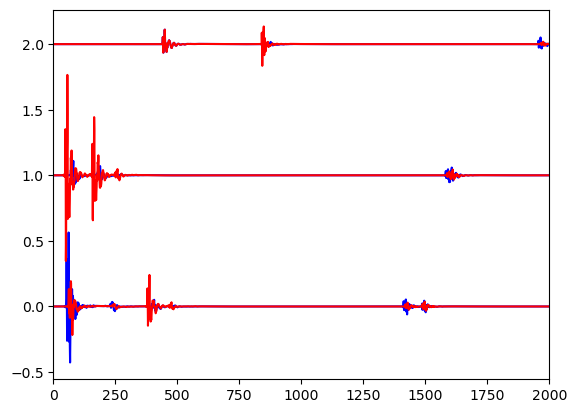

In [51]:
fig, ax = plt.subplots()

for itr0 in range(brir.shape[0]):
    ax.plot(brir[itr0, :, 0] + itr0, 'b')
    ax.plot(brir[itr0, :, 1] + itr0, 'r')
ax.set_xlim([0, 2000])
plt.show()


In [19]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl'
df = pd.read_pickle(fn)

df = df[df.index_room == 0]
df = df.groupby(['src_azim', 'src_elev']).agg({'index_brir': list}).reset_index()
map_loc_to_index_brir = {}
for key, val in zip(zip(df.src_azim, df.src_elev), df.index_brir):
    map_loc_to_index_brir[key] = val
map_loc_to_index_brir


{(0, -40): [0, 792],
 (0, -30): [1, 793],
 (0, -20): [2, 794],
 (0, -10): [3, 795],
 (0, 0): [4, 796],
 (0, 10): [5, 797],
 (0, 20): [6, 798],
 (0, 30): [7, 799],
 (0, 40): [8, 800],
 (0, 50): [9, 801],
 (0, 60): [10, 802],
 (5, -40): [11, 803],
 (5, -30): [12, 804],
 (5, -20): [13, 805],
 (5, -10): [14, 806],
 (5, 0): [15, 807],
 (5, 10): [16, 808],
 (5, 20): [17, 809],
 (5, 30): [18, 810],
 (5, 40): [19, 811],
 (5, 50): [20, 812],
 (5, 60): [21, 813],
 (10, -40): [22, 814],
 (10, -30): [23, 815],
 (10, -20): [24, 816],
 (10, -10): [25, 817],
 (10, 0): [26, 818],
 (10, 10): [27, 819],
 (10, 20): [28, 820],
 (10, 30): [29, 821],
 (10, 40): [30, 822],
 (10, 50): [31, 823],
 (10, 60): [32, 824],
 (15, -40): [33, 825],
 (15, -30): [34, 826],
 (15, -20): [35, 827],
 (15, -10): [36, 828],
 (15, 0): [37, 829],
 (15, 10): [38, 830],
 (15, 20): [39, 831],
 (15, 30): [40, 832],
 (15, 40): [41, 833],
 (15, 50): [42, 834],
 (15, 60): [43, 835],
 (20, -40): [44, 836],
 (20, -30): [45, 837],
 (20, 

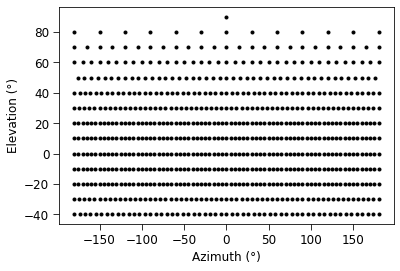

In [9]:
hrtf_locs, hrtf_firs, hrtf_sr = simulator.load_kemar_hrtfs(npz_filename='kemar_hrtfs/hrtfs.npz')

IDX_nonzero_azim = hrtf_locs[:, 1] != 0
opposite_hrtf_locs = hrtf_locs[IDX_nonzero_azim, :]
opposite_hrtf_locs[:, 1] = -1 * opposite_hrtf_locs[:, 1] # Multiply azimuth by negative one
opposite_hrtf_firs = np.flip(hrtf_firs[IDX_nonzero_azim, :, :], axis=2) # Switch left/right channel
hrtf_locs = np.concatenate([opposite_hrtf_locs, hrtf_locs], axis=0)
hrtf_firs = np.concatenate([opposite_hrtf_firs, hrtf_firs], axis=0)
hrtf_locs.shape, hrtf_firs.shape

"""
Check kemar_hrtf locations (azimuths and elevations)
"""
fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Azimuth (°)',
    str_ylabel='Elevation (°)')
plt.show()


In [ ]:
"""
Run this cell to start the MATLAB engine for Python and import `simulator_matlab`
"""
import matlab.engine
import simulator_matlab
importlib.reload(simulator_matlab)

eng = matlab.engine.start_matlab();
if 'src/' not in eng.path():
    eng.addpath('src/');


In [ ]:
"""
Quit MATLAB engine
"""
eng.quit()


In [ ]:
"""
DEBUGGING: CLOSELY COMPARE MATLAB AND PYTHON SIMULATORS UNDER DIFFERENT CONDITIONS

NOTES:
- Resulting BRIRs are sometimes offset by one or two samples
    - May be due to an off-by-one indexing error when porting MATLAB to Python
    - May be due to numerical precision differences
"""
room_materials = [26]*6#[1, 1, 1, 1, 15, 16]
room_dim_xyz = [7, 8, 4]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = -49
src_azim = 145
src_elev = 20
src_dist = 3.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

importlib.reload(simulator)

np.random.seed(0)
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=8,
    strict=True,
    verbose=2)


In [ ]:
importlib.reload(simulator_matlab)

np.random.seed(0)
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    eng=eng)


In [ ]:
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_python = brir_python[1:]
offset_brir_matlab = brir_matlab[:-1]

ax_arr[0].plot(offset_brir_python[:, 0], 'b')
ax_arr[0].plot(offset_brir_python[:, 1], 'r')
ax_arr[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax_arr[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')
ax_arr[1].plot(offset_brir_python[:, 0] - offset_brir_matlab[:, 0], 'b')
ax_arr[1].plot(offset_brir_python[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 500],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


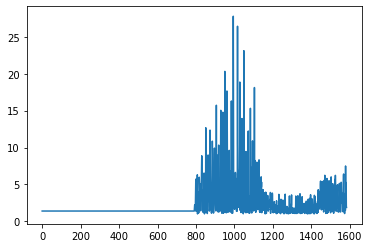

AZIM:70.0, ELEV:0.0, DIST:20.315961431695275


In [105]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/room0008.hdf5'
with h5py.File(fn, 'r') as f:
    list_brir = f['brir'][:]
    list_src_dist = f['src_dist'][:]
    list_src_azim = f['src_azim'][:]
    list_src_elev = f['src_elev'][:]
    sr = f['sr'][0]

fig, ax = plt.subplots()
ax.plot(list_src_dist)
# ax.plot(list_src_azim)
# ax.plot(list_src_elev)
plt.show()

idx = np.random.randint(800, 1100)
brir = list_brir[idx]
azim = list_src_azim[idx]
elev = list_src_elev[idx]
dist = list_src_dist[idx]

print(f"AZIM:{azim}, ELEV:{elev}, DIST:{dist}")


In [106]:
fn_audio = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr_audio = sf.read(fn_audio)

# Replace example audio clip with noise bursts
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr_audio
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
fn_audio = 'WHITE NOISE BURSTS'

print(f'Example audio: {fn_audio} (shape={y.shape}, sr={sr_audio})')
# ipd.display(ipd.Audio(rate=sr_audio, data=y))

y_spatialized = util_stimuli.spatialize_sound(y, brir)
ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))


Example audio: WHITE NOISE BURSTS (shape=(132300,), sr=44100)


In [107]:
fn_manifest_brir = "/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl"
index_room = 8
df_manifest_brir = pd.read_pickle(fn_manifest_brir)
df = df_manifest_brir[df_manifest_brir.index_room == index_room]
df


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,sr,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance
12672,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,0,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-40,True,True,True,False
12673,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-30,True,True,True,False
12674,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,2,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-20,True,True,True,False
12675,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,3,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,-10,True,True,True,False
12676,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,4,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,0,1.400000,0,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14251,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1579,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,3.571293,20,True,True,True,False
14252,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1580,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,4.581923,30,True,True,True,False
14253,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1581,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,5.253641,40,True,True,True,False
14254,0,344.5,0.5,43.391167,"[21.909683554280686, 1.860689033145374, 1.3088...",True,1582,8,"[27.90370793347436, 22.198099561509903, 4.9147...","[8, 1, 1, 8, 1, 3]",44100,355,2.046637,50,True,True,True,False


In [22]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(100):
    np.random.seed(_)
    room_parameters = generate_brir_manifest.sample_room_parameters(
        verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(
        room_dim_xyz=room_parameters['room_dim_xyz'],
        verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_azim = 0
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer = 0
    for src_azim in range(0, 360, 15):
        for src_elev in range(-60, 61, 5):
            src_dist = generate_brir_manifest.distance_to_wall(
                room_dim_xyz,
                head_pos_xyz,
                head_azim,
                src_azim,
                src_elev)
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer), "Invalid head position"
            if (np.sum(np.isclose(src_pos_xyz, 0)) == 1) or (np.sum(np.isclose(src_pos_xyz, room_dim_xyz)) == 1):
                pass
            else:
                print(src_azim, src_elev, room_dim_xyz, src_pos_xyz)


/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/generate_brir_manifest.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))


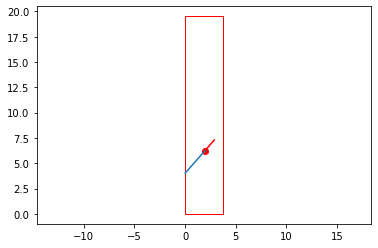

Checked src_azim: -180 = 180.0


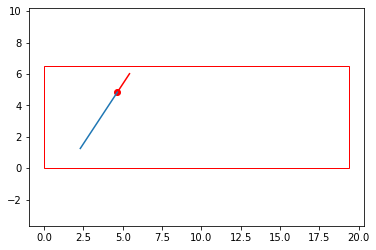

Checked src_azim: -180 = 180.0


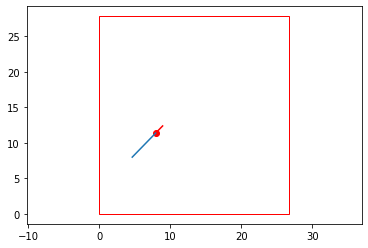

Checked src_azim: -180 = 180.0


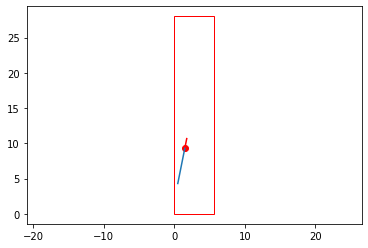

Checked src_azim: -180 = 179.99999914622634


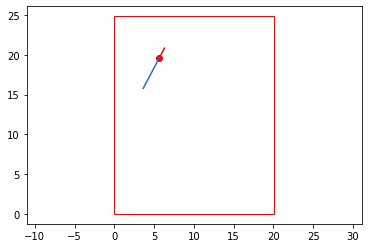

Checked src_azim: -180 = 179.99999914622634


In [23]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(5):
    room_parameters = generate_brir_manifest.sample_room_parameters(verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    
    fig, ax = plt.subplots()
    rect = matplotlib.patches.Rectangle((0, 0), room_dim_xyz[0], room_dim_xyz[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.plot(head_pos_xyz[0], head_pos_xyz[1], 'ro')
    src_azim = -180
    src_elev = 20
    src_dist = generate_brir_manifest.distance_to_wall(
        room_dim_xyz,
        head_pos_xyz,
        head_azim=head_azim,
        src_azim=src_azim,
        src_elev=src_elev)
    dhx = 1.4 * np.cos(np.deg2rad(head_azim))
    dhy = 1.4 * np.sin(np.deg2rad(head_azim))
    dx = src_dist * np.cos(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    dy = src_dist * np.sin(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dhx], [head_pos_xyz[1], head_pos_xyz[1] + dhy], 'r-')
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dx], [head_pos_xyz[1], head_pos_xyz[1] + dy])
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
    vector1 = np.array([dx, dy])
    vector2 = np.array([dhx, dhy])
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.rad2deg(np.arccos(dot_product))
    print(f'Checked src_azim: {src_azim} = {angle}')
